In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import znnl as nl

Using backend: cpu

Available hardware:

TFRT_CPU_0

In [104]:
# load data
lossnames = ["CrossEntropy", "LPNorm2", "MeanPowerLoss2"]
path = ""  # "C:/Users/Admin/Uni/Talks/dpg-fruehjahrstagung-2024/Experiments/"
recordernames = ["l_train_recorder_", "r_train_recorder_", "test_recorder_"]
recorders = dict()
reports = dict()

for lossname in lossnames:
    print("Loading " + lossname + "...")
    for recordername in recordernames:
        recorders[recordername + lossname] = nl.training_recording.DataStorage(
            path + recordername + lossname
        )
        if recordername[:4] == "test":
            reports[recordername + lossname] = recorders[
                recordername + lossname
            ].fetch_data(["loss", "accuracy"])
        else:
            reports[recordername + lossname] = recorders[
                recordername + lossname
            ].fetch_data(
                ["loss", "accuracy", "eigenvalues", "entropy", "covariance_entropy", "trace"]
            )

Loading CrossEntropy...
Loading LPNorm2...
Loading MeanPowerLoss2...


In [105]:
plt.style.use("Plotstyle.mplstyle")

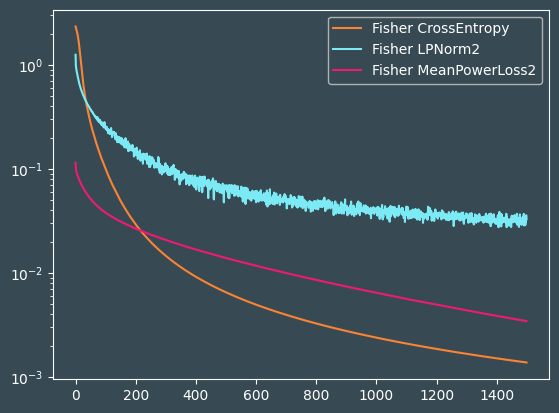

In [106]:
# Plot loss
for lossname in lossnames:
    plt.plot(
        reports["l_train_recorder_" + lossname]["loss"], label=f"Fisher {lossname}"
    )
plt.legend()
plt.yscale("log")
plt.show()

In [160]:
class NeonHue:
    def __init__(self, resolution=10, max_width=10):
        self.resolution = resolution
        self.max_width = max_width

    def plot(self, ax, *args, **kwargs):
        start_alpha = kwargs.get("alpha")
        start_width = kwargs.get("linewidth")
        if start_width is None:
            start_width = 1

        for i in range(self.resolution):
            kwargs["alpha"] = np.exp(-10*i/self.resolution)*start_alpha
            kwargs["linewidth"] = start_width +  (i / self.resolution)*(self.max_width  - start_width)
            #if i != 0:
                #kwargs["label"] = None
            ax.plot(*args, **kwargs)

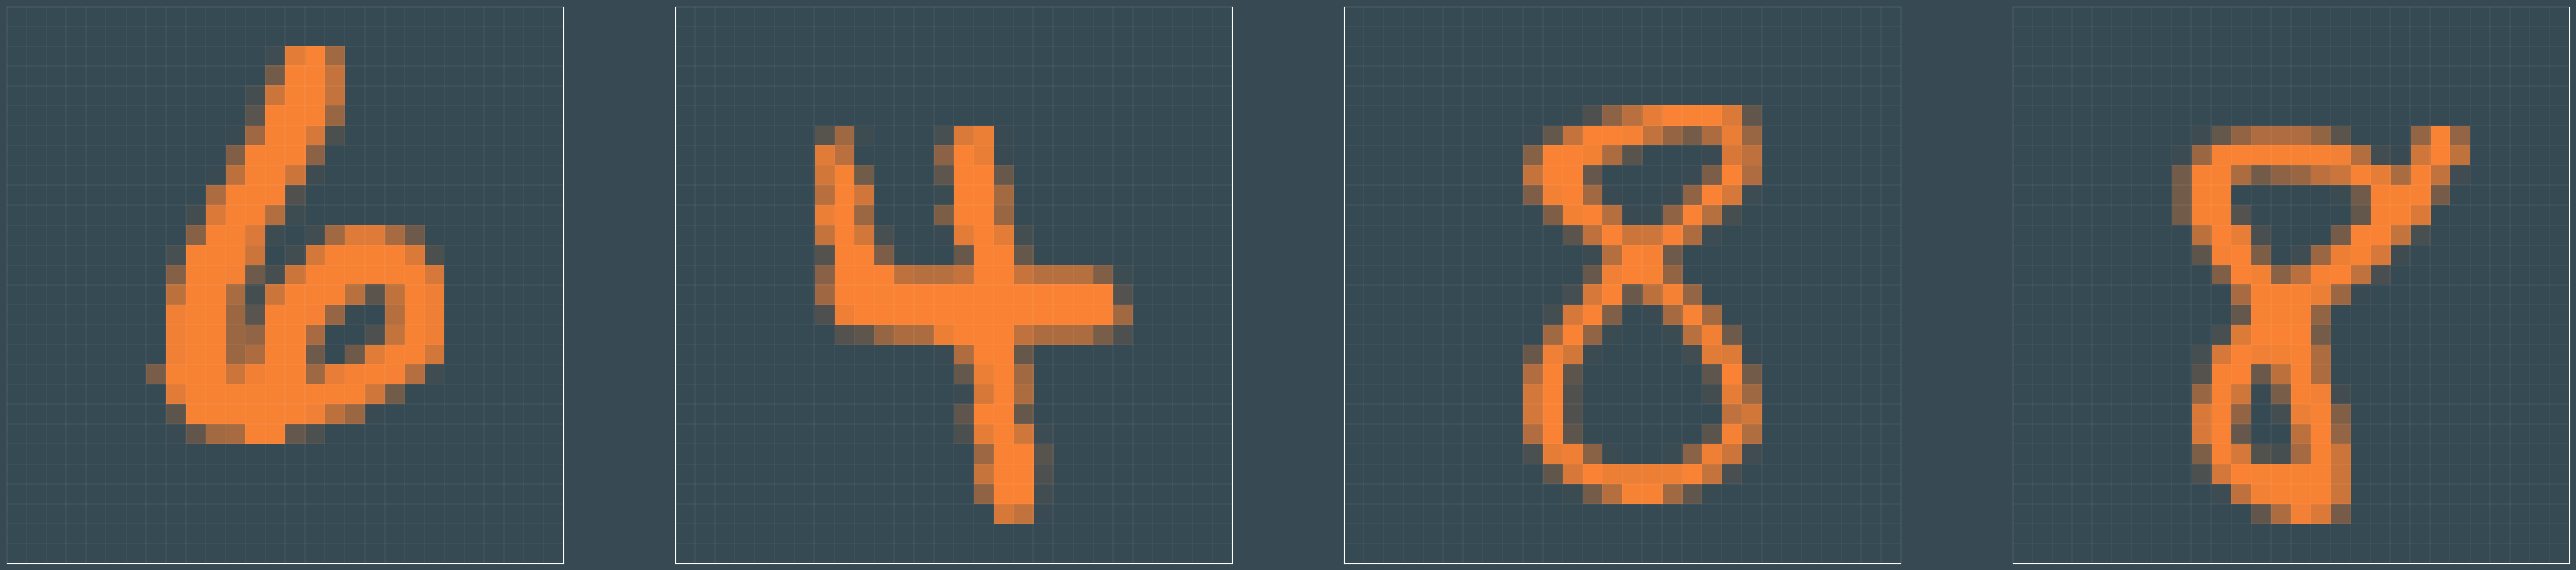

In [161]:
# Plotting MNIST
from keras.datasets import mnist
import matplotlib.pyplot as plt 
import numpy as np

from matplotlib.colors import LinearSegmentedColormap

colors = {'red':   [(0.0, .2156, .2156), (1.0, 0.98, 0.98)],
          'green': [(0.0, .2902, .2902), (1.0, 0.514, 0.514)],
          'blue':  [(0.0, .3255, .3255), (1.0, 0.204, 0.204)]}

custom_cmap = LinearSegmentedColormap('CustomColormap', colors)


(train_X, train_y), (test_X, test_y) = mnist.load_data()
n_plots = 4
fig, ax = plt.subplots(1,n_plots, figsize=(50,50))
for i in range(n_plots):  
    index = np.random.randint(len(train_X))
    axis = ax[i]
    axis.imshow(train_X[index], cmap=custom_cmap)
    axis.set_yticklabels([])
    axis.set_xticklabels([])
    axis.set_xticks(np.arange(28)-0.5)
    axis.set_yticks(np.arange(28)-0.5)
    axis.tick_params(left = False, bottom = False)
    axis.grid(color='white', linestyle='-', linewidth=0.06)

plt.savefig('mnist_plot.pdf', bbox_inches='tight')

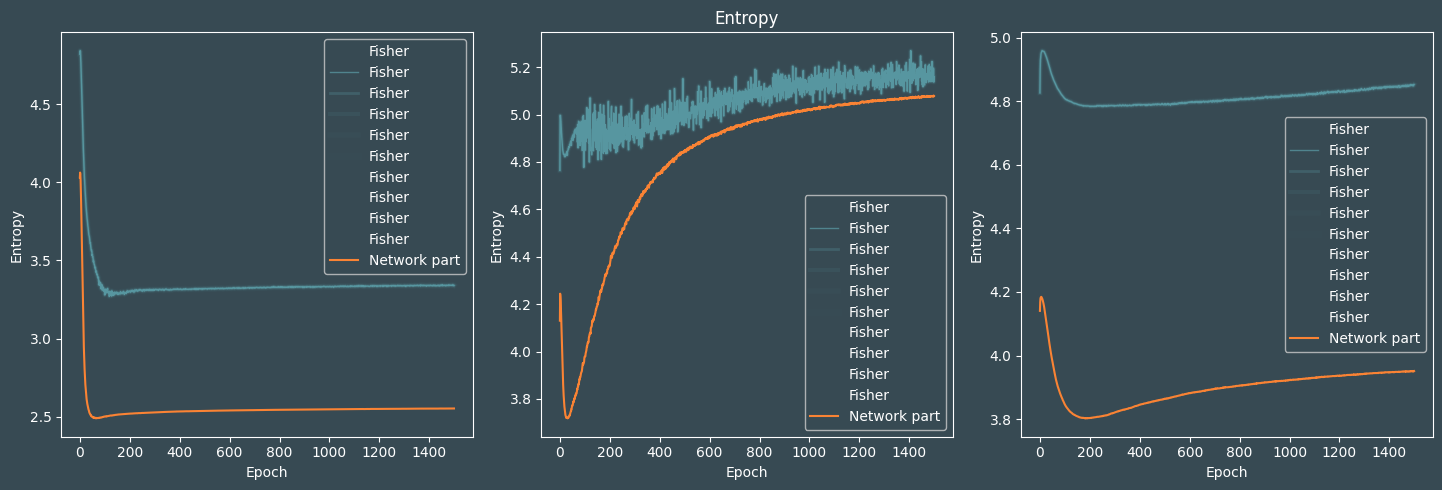

In [162]:
# plot r and l entropy for all losses

neon = NeonHue()

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, lossname in enumerate(lossnames):
    axis = ax[i]
    neon.plot(axis, reports["l_train_recorder_" + lossname]["entropy"], label=f"Fisher", color = "C1")
    axis.plot(reports["r_train_recorder_" + lossname]["entropy"], label=f"Network part")
    axis.legend()
    axis.set_xlabel("Epoch")
    axis.set_ylabel("Entropy")
ax[1].set_title("Entropy")

plt.tight_layout(rect=(0,0,0.97,1))
#plt.savefig('Resultplots/entropy_plot.png', dpi=600, transparent=True)

plt.show()

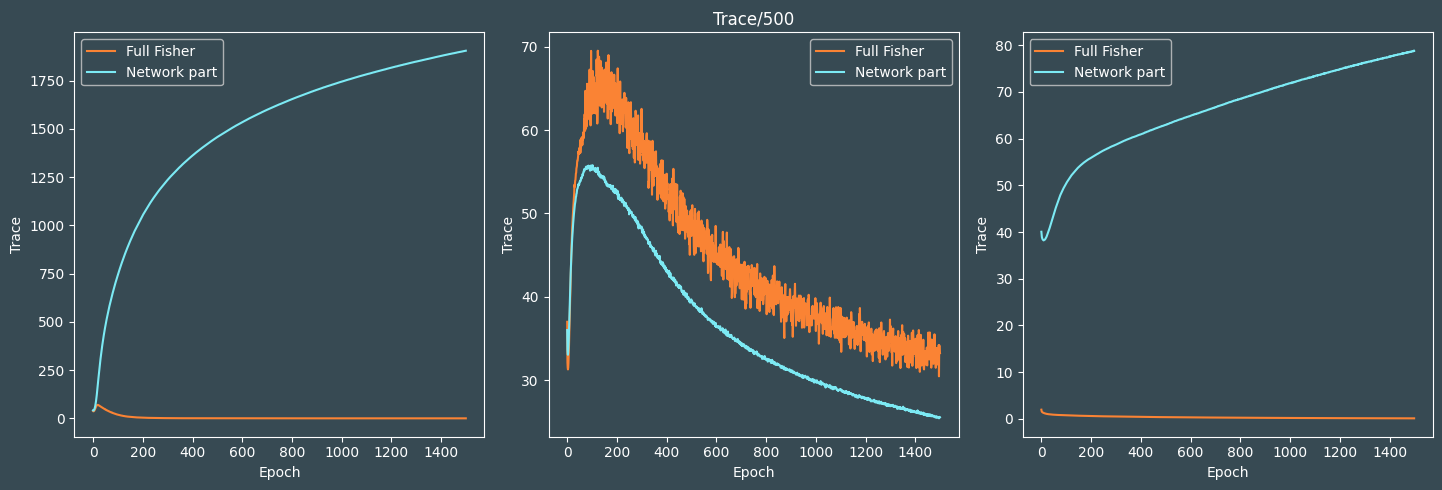

In [137]:
# plot r and l trace for all losses

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, lossname in enumerate(lossnames):
    axis = ax[i]
    axis.plot(reports["l_train_recorder_" + lossname]["trace"]/500, label=f"Full Fisher")
    axis.plot(reports["r_train_recorder_" + lossname]["trace"]/500, label=f"Network part")
    axis.legend()
    axis.set_xlabel("Epoch")
    axis.set_ylabel("Trace")

ax[1].set_title("Trace/500")
plt.tight_layout(rect=(0,0,0.97,1))
plt.savefig('Resultplots/trace_plot.png', dpi=600, transparent=True)
plt.show()